# RMSProp

我们在[“Adagrad”](adagrad.md)一节里提到，由于调整学习率时分母上的变量 $\boldsymbol{s}_t$ 一直在累加按元素平方的小批量随机梯度，目标函数自变量每个元素的学习率在迭代过程中一直在降低（或不变）。所以，当学习率在迭代早期降得较快且当前解依然不佳时，Adagrad 在迭代后期由于学习率过小，可能较难找到一个有用的解。为了应对这一问题，RMSProp 算法对 Adagrad 做了一点小小的修改 [1]。

## 算法

我们在[“动量法”](momentum.md)一节里介绍过指数加权移动平均。不同于 Adagrad 里状态变量 $\boldsymbol{s}_t$ 是截至时间步 $t$ 所有小批量随机梯度 $\boldsymbol{g}_t$ 按元素平方和，RMSProp 将这些梯度按元素平方做指数加权移动平均。具体来说，给定超参数 $0 \leq \gamma < 1$，RMSProp 在时间步 $t>0$ 计算

$$\boldsymbol{s}_t \leftarrow \gamma \boldsymbol{s}_{t-1} + (1 - \gamma) \boldsymbol{g}_t \odot \boldsymbol{g}_t. $$

和 Adagrad 一样，RMSProp 将目标函数自变量中每个元素的学习率通过按元素运算重新调整，然后更新自变量

$$\boldsymbol{x}_t \leftarrow \boldsymbol{x}_{t-1} - \frac{\eta}{\sqrt{\boldsymbol{s}_t + \epsilon}} \odot \boldsymbol{g}_t, $$

其中 $\eta$ 是学习率，$\epsilon$ 是为了维持数值稳定性而添加的常数，例如 $10^{-6}$。因为 RMSProp 的状态变量是对平方项 $\boldsymbol{g}_t \odot \boldsymbol{g}_t$ 的指数加权移动平均，所以可以看作是最近 $1/(1-\gamma)$ 个时间步的小批量随机梯度平方项的加权平均。如此一来，自变量每个元素的学习率在迭代过程中不再一直降低（或不变）。

照例，让我们先观察 RMSProp 对目标函数 $f(\boldsymbol{x})=0.1x_1^2+2x_2^2$ 中自变量的迭代轨迹。回忆在[“Adagrad”](adagrad.md)一节使用学习率为 0.4 的 Adagrad，自变量在迭代后期的移动幅度较小。但在同样的学习率下，RMSProp 可以较快逼近最优解。

epoch 20, x1 -0.010599, x2 0.000000


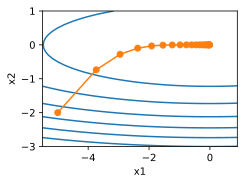

In [1]:
%matplotlib inline
import d2lzh as d2l
import math
from mxnet import nd

def rmsprop_2d(x1, x2, s1, s2):
    g1, g2, eps = 0.2 * x1, 4 * x2, 1e-6
    s1 = gamma * s1 + (1 - gamma) * g1 ** 2
    s2 = gamma * s2 + (1 - gamma) * g2 ** 2
    x1 -= eta / math.sqrt(s1 + eps) * g1
    x2 -= eta / math.sqrt(s2 + eps) * g2
    return x1, x2, s1, s2

def f_2d(x1, x2):
    return 0.1 * x1 ** 2 + 2 * x2 ** 2

eta, gamma = 0.4, 0.9
d2l.show_trace_2d(f_2d, d2l.train_2d(rmsprop_2d))

## 从零开始实现

接下来按照算法中的公式实现 RMSProp。

In [2]:
features, labels = d2l.get_data_ch7()

def init_rmsprop_states():
    s_w = nd.zeros((features.shape[1], 1))
    s_b = nd.zeros(1)
    return (s_w, s_b)

def rmsprop(params, states, hyperparams):
    gamma, eps = hyperparams['gamma'], 1e-6
    for p, s in zip(params, states):
        s[:] = gamma * s + (1 - gamma) * p.grad.square()
        p[:] -= hyperparams['lr'] * p.grad / (s + eps).sqrt()

我们将初始学习率设为 0.01，并将超参数 $\gamma$ 设为 0.9。此时，变量 $\boldsymbol{s}_t$ 可看作是最近 $1/(1-0.9) = 10$ 个时间步的平方项 $\boldsymbol{g}_t \odot \boldsymbol{g}_t$ 的加权平均。

loss: 0.244675, 0.383483 sec per epoch


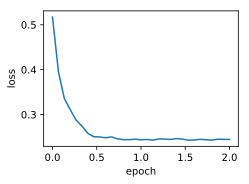

In [3]:
features, labels = d2l.get_data_ch7()
d2l.train_ch7(rmsprop, init_rmsprop_states(), {'lr': 0.01, 'gamma': 0.9},
              features, labels)

## 简洁实现

通过算法名称为“rmsprop”的`Trainer`实例，我们便可使用 Gluon 提供的 RMSProp 算法来训练模型。注意超参数 $\gamma$ 通过`gamma1`指定。

loss: 0.243380, 0.250981 sec per epoch


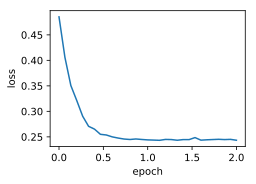

In [4]:
d2l.train_gluon_ch7('rmsprop', {'learning_rate': 0.01, 'gamma1': 0.9},
                    features, labels)

## 小结

* RMSProp 和 Adagrad 的不同在于，RMSProp 使用了小批量随机梯度按元素平方的指数加权移动平均来调整学习率。

## 练习

* 把 $\gamma$ 的值设为 1，实验结果有什么变化？为什么？
* 试着使用其他的初始学习率和 $\gamma$ 超参数的组合，观察并分析实验结果。

## 扫码直达[讨论区](https://discuss.gluon.ai/t/topic/2275)


![](../img/qr_rmsprop.svg)

## 参考文献

[1] Tieleman, T., & Hinton, G. (2012). Lecture 6.5-rmsprop: Divide the gradient by a running average of its recent magnitude. COURSERA: Neural networks for machine learning, 4(2), 26-31.